#### In this experiment we will implement a Support Vector Machine (SVM) to classify two different classes in our dataset. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cvxopt

%matplotlib inline

#### Generating a random dataset
In order to generate our dataset, we simply draw $n=100$ points (2-D vectors) $\mathbf{x}_1, . . . , \mathbf{x}_{100}$ independently and uniformly at random on $[0, 1]^2$. These $\mathbf{x}_i=\begin{bmatrix}
    x_{i1}\\
    x_{i2}
\end{bmatrix}$ will be our input patterns.

In [3]:
n=100
x1 = np.random.uniform(0,1,(n,1))
x2 = np.random.uniform(0,1,(n,1))
x = np.concatenate((x1, x2), axis = 1)

Moreover, given a sample point $\mathbf{x}_i$, we assign a class $d_i$ to each point using,
\begin{equation}
d_i=\Big\{^{1,\,\,\, x_{i2} <\frac{1}{5}
sin(10x_{i1}) + 0.3\,\,\, \text{or}\,\,\, (x_{i2} − 0.8)^2 + (x_{i1} − 0.5)^2 < 0.152}_{-1,\,\,\, otherwise}
\end{equation}
where $d_i$ denote the desired classes corresponding to the input patterns.

In [4]:
# Generating the desired class corresponding to the input data
d = np.zeros((n,1))
#np.power(np.power(x[i][1],2)-0.8,2)+np.power(np.power(x[i][0],2)-0.5,2)<np.power(0.15,2))
for i in range(n):
    if ((0.2*np.sin(10*x[i][0]) + 0.3>x[i][1]) or (np.power((x[i][1]-0.8),2) + np.power((x[i][0]-0.5),2)<np.power(0.15,2))):
        d[i] = 1
    else:
        d[i] = -1       

The following figure illustrates the sample points and the corresponding classes (red and blue).

Text(0.5,1,u'Input data, N = 100')

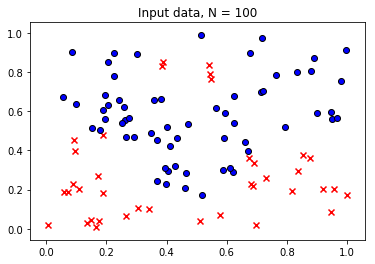

In [5]:
# Visualization of data points
for i in range(n):
    if d[i]==1:
        plt.scatter(x[i][0], x[i][1], color='red',marker='x',edgecolors='k')
    else:
        plt.scatter(x[i][0], x[i][1], color='blue',edgecolors='k')
plt.title('Input data, N = %s'%(n))


### Support Vector Machine
Now, we want to choose an appropriate Kernel function and design a SVM that separates the classes $C_1 = \{\mathbf{x}_i: d_i = 1\}\,\, \text{and}\,\, C_{−1} = \{\mathbf{x}_i: d_i = −1\}$.

#### Kernel Function:
The input data is not linearly separable. So, we need to use a kernel function to take our data into another vector space in which we can separate the two classes linearly.<br> For this purpose, we use the Radial Basis Function (RBF) kernel. We define the RBF kernel $K(x_i,x_j)$ as,<br>
$\mathbf{K(x_i,x_j)=exp(-\gamma||x_i-x_j||^2)}$, <br>
where $\mathbf{\gamma = 7}$ in this letter.

In [69]:
## Calculating the Kernel matrix K:
def kernel(x,y):
    return np.exp(-7*np.power(np.linalg.norm(x-y),2))
#def kernel(x,y):
#    return np.power((1+np.dot(x,y.T)),2)
#def kernel(x,y):
#    return (1+np.dot(x,y))**3
K = np.zeros((n,n))
#KK = np.zeros((n,n))

for i in range(n):
    for j in range(n):
        #K[i,j] = np.exp(-0.5*np.power(np.linalg.norm(x[i]-x[j]),2))
        K[i,j]=kernel(x[i],x[j])

##### Problem Formulaton:
In SVM we seek to solve the following optimization problem:<br>
\begin{equation*}
\begin{aligned}
& \underset{w}{\text{minimize}}
& & \frac{1}{2}w^Tw \\
& \text{subject to}
& & y_i(w^Tx_i + b) \geq 1, \; i = 1, \ldots, n.
\end{aligned}
\end{equation*}<br>
Now, we re-write the above optimization problem using the Lagrange multipliers $\alpha$,<br>
\begin{equation}
\begin{aligned}
& \underset{\alpha}{\text{maximize}}
& & \sum_{i=1}^{N}\alpha_i - \frac{1}{2}\sum_{i=1}^{n}\sum\limits_{j=1}^{n}y_iy_j\alpha_i\alpha_jx_i^Tx_j \\
& \text{subject to}
& & \alpha_i \geq 0, \; i = 1, \ldots, n.\text{ And, }
\sum_{i=1}^{n}\alpha_iy_i = 0
\end{aligned}
\end{equation}<br>
This is a cone quadratic program which has the general form of,<br>
\begin{equation*}
\begin{aligned}
& \underset{x}{\text{minimize}}
& & (1/2)x^TPx + cTx \\
& \text{subject to}
& & Gx\leq h\text{, }
Ax=b
\end{aligned}
\end{equation*}<br>
Now we rewrite the SVM optimization problem into the general form of the cone quadratic programming described above. That is,<br>
\begin{equation*}
\begin{aligned}
& \underset{x}{\text{minimize}}
& & (1/2)\alpha^TP\alpha + (-\mathbb{1}^T\alpha) \\
& \text{subject to}
& & G\alpha\leq \mathbb{0}\text{, }
y^T\alpha=0
\end{aligned}
\end{equation*}<br>
where $g = diag\{-1,-1, \dots,-1\}$, and $[P]_{ij}=y_iy_jK(x_i,x_j)$. <br><br>
Next, we solve this cone quadratic program using the *CVXOPT* library.

In [70]:
P = cvxopt.matrix(np.outer(d, d) * K)
#P = cvxopt.matrix(K)
c = cvxopt.matrix(-np.ones(n))
G = cvxopt.matrix(-np.eye(n))
h = cvxopt.matrix(np.zeros(n))
A = cvxopt.matrix(d, (1,n))
b = cvxopt.matrix(0.0)
cvxopt.solvers.options['show_progress'] = True
solution = cvxopt.solvers.qp(P, c, G, h, A, b)
a = np.ravel(solution['x']) #Extracting the alphas from the solutions
a_eff = a > 1e-4 #Choosing the non-zero values of a
a_eff_indices = np.arange(n)[a_eff]  #Extracting the indices of non-zero elements in alpha. 
sv_a = a[a_eff_indices]
sv_x = x[a_eff_indices]
sv_d = d[a_eff_indices]
print("\n---------\nTotal Number of Support Vectors: %d \n---------" %(len(sv_a)))
#sv_d

     pcost       dcost       gap    pres   dres
 0: -3.2618e+01 -9.9678e+01  3e+02  1e+01  3e+00
 1: -1.0895e+02 -2.0597e+02  2e+02  5e+00  1e+00
 2: -2.3571e+02 -3.4926e+02  2e+02  4e+00  1e+00
 3: -4.5931e+02 -5.8953e+02  2e+02  4e+00  1e+00
 4: -1.6254e+03 -1.8292e+03  3e+02  4e+00  1e+00
 5: -3.3705e+03 -3.7782e+03  5e+02  4e+00  1e+00
 6: -6.6375e+03 -7.7203e+03  1e+03  4e+00  9e-01
 7: -1.2480e+04 -1.5460e+04  3e+03  3e+00  8e-01
 8: -1.7615e+04 -2.1151e+04  4e+03  1e+00  3e-01
 9: -1.8557e+04 -1.9173e+04  6e+02  2e-01  4e-02
10: -1.8578e+04 -1.8586e+04  8e+00  2e-03  5e-04
11: -1.8578e+04 -1.8578e+04  8e-02  2e-05  5e-06
12: -1.8578e+04 -1.8578e+04  8e-04  2e-07  5e-08
13: -1.8578e+04 -1.8578e+04  8e-06  2e-09  5e-10
Optimal solution found.

---------
Total Number of Support Vectors: 15 
---------


##### Visualizing Support Vectors

Text(0.5,1,u'Support Vectors')

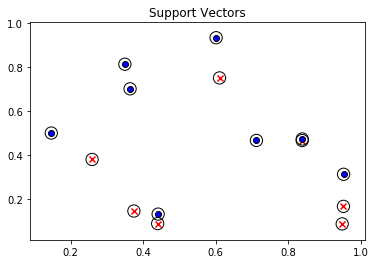

In [71]:
for i in range(len(a_eff_indices)):
    if sv_d[i]==1:
        plt.scatter(sv_x[i][0], sv_x[i][1], color = 'red',marker='x', edgecolors='k')
        plt.scatter(sv_x[i][0], sv_x[i][1], edgecolors='k',facecolors='none', s=150)
    else:
        plt.scatter(sv_x[i][0], sv_x[i][1], color = 'blue', edgecolors='k')
        plt.scatter(sv_x[i][0], sv_x[i][1], edgecolors='k',facecolors='none', s=150)
plt.title('Support Vectors')

Now, we find the bias value:

In [72]:
b=np.zeros((len(a_eff_indices),1))
for j in range(len(a_eff_indices)):
    for i in range(len(a_eff_indices)):
        b[j]-=sv_a[i]*sv_d[i]*K[j,a_eff_indices[i]]
b = np.sum(b)/len(a_eff_indices)
print ("b = %f" %(b))

b = -8.724629


In [73]:
def predict(unknown,a,b,x,d,k): # The discriminator function
    g=0
    for i in range(len(x)):
        g+= a[i] * d[i] * k(unknown,x[i])
    return np.sign(g+b)

In [74]:
#x_grid = np.linspace(0,1,100)
#for i in range(len(x_grid)):
#    for j in range(len(x_grid)):
#        if predict(np.array([x_grid[i],x_grid[j]]),sv_a,b,sv_x,sv_d,kernel) > 0:
#            plt.scatter(x_grid[i], x_grid[j], color = 'black')
#xlist = np.linspace(0.0, 1.0, 100)
#ylist = np.linspace(0.0, 1.0, 100)
#X,Y = np.meshgrid(xlist, ylist)
#vfunc = np.vectorize(predict)
#Z = vfunc()
correct=0
for i in range(n):
    if predict(x[i],sv_a,b,sv_x,sv_d,kernel) == d[i]:
        correct+=1
print ("Total number of correctly classified inputs: %d out of %d " %(correct,n))

Total number of correctly classified inputs: 72 out of 100 


#### Visualizing The Hypothesis
Recall that the result of the SVM will be a discriminant function $g(\mathbf{x}) = \sum^{\mathcal{I}_s}_{i=1} \alpha_id_iK(x_i
, x) +\theta,$
where $\alpha_i$ are some positive constants, $\mathcal{I}_s$ is the set of the indices of support vectors, and $\theta$ is the optimal bias.
Now we provide a rough sketch of the following decision boundaries,<br>
$\mathcal{H}\triangleq\{\mathbf{x} : g(\mathbf{x}) = 0\}$<br>
$\mathcal{H}^{+}\triangleq\{\mathbf{x} : g(\mathbf{x}) = 1\}$<br>
$\mathcal{H}^{-}\triangleq\{\mathbf{x} : g(\mathbf{x}) = -1\}$

In [75]:
def predict_plot(unknown,a,b,x,d,k): # The discriminator function without labeling the output (I just removed np.sign)
    g=0
    for i in range(len(x)):
        g+= a[i] * d[i] * k(unknown,x[i])
    return g+b

In [60]:
#xlist = np.linspace(0.0, 1.0, 100)
#ylist = np.linspace(0.0, 1.0, 100)
#X,Y = np.meshgrid(xlist, ylist)
#vfunc = np.vectorize(predict)
#Z = vfunc()
#vfunc(np.array([x_list,y_list]),sv_a,b,sv_x,sv_d,kernel)

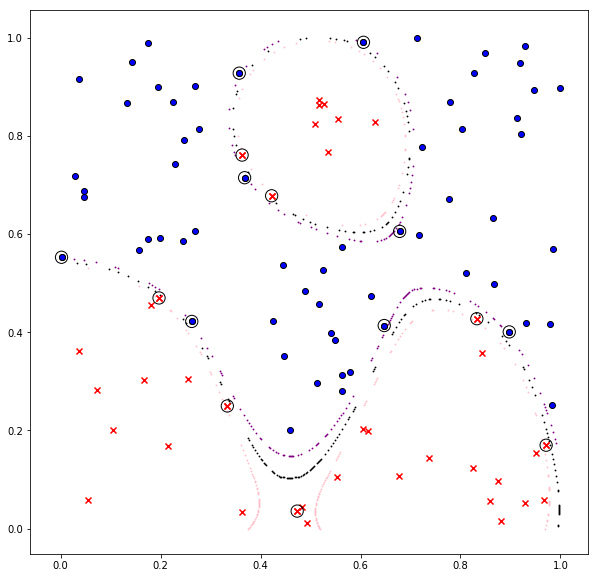

In [61]:
epsilon = 1e-2
x_grid = np.linspace(0,1,500)
plt.figure(figsize=(10,10))

for i in range(len(x_grid)):
    for j in range(len(x_grid)):
        temp=predict_plot(np.array([x_grid[i],x_grid[j]]),sv_a,b,sv_x,sv_d,kernel)
        if np.abs(temp) < epsilon:
            plt.scatter(x_grid[i], x_grid[j], color = 'black',s=0.7)
        elif(np.abs(temp-1)<epsilon):
            plt.scatter(x_grid[i], x_grid[j], color = 'pink',s=0.7)
        elif(np.abs(temp+1)<epsilon):
            plt.scatter(x_grid[i], x_grid[j], color = 'purple',s=0.7)
for i in range(n):
    if d[i]==1:
        plt.scatter(x[i][0], x[i][1], color='red',marker='x',edgecolors='k')
    else:
        plt.scatter(x[i][0], x[i][1], color='blue',edgecolors='k')
for i in range(len(a_eff_indices)):
    if sv_d[i]==1:
        plt.scatter(sv_x[i][0], sv_x[i][1], color = 'red',marker='x', edgecolors='k')
        plt.scatter(sv_x[i][0], sv_x[i][1], edgecolors='k',facecolors='none', s=150)
    else:
        plt.scatter(sv_x[i][0], sv_x[i][1], color = 'blue', edgecolors='k')
        plt.scatter(sv_x[i][0], sv_x[i][1], edgecolors='k',facecolors='none', s=150)